# Traffic and R_eff

Let's examine whether general traffic can explain changes in the effective reproductive ratio, as estimated by Price 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')
from datetime import datetime as dt
from Reff_functions import *
from Reff_constants import *

Read in all the data

In [2]:
# Reff estimates from Price et al 2020
df_Reff = read_in_Reff() #estimates up to 14th April

#from data, find rho
from datetime import timedelta
df_NNDSS = pd.read_excel("../data/COVID-19 UoM 29JUN2020 0900.xlsx",
                   parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                   dtype= {'PLACE_OF_ACQUISITION':str})
df_NNDSS.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

df_NNDSS['date_inferred'] = df_NNDSS.TRUE_ONSET_DATE
df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
df_NNDSS.loc[df_NNDSS.date_inferred.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=1)

df_NNDSS['imported'] = df_NNDSS.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
df_NNDSS['local'] = 1 - df_NNDSS.imported


df_state = df_NNDSS[['date_inferred','STATE','imported','local']].groupby(['STATE','date_inferred']).sum()

df_state['rho'] = [ 0 if (i+l == 0) else i/(i+l) for l,i in zip(df_state.local,df_state.imported)  ]

df_Reff = read_in_Reff()
df_Reff = df_Reff.merge(df_state,how='left',left_on=['state','date'], right_on=['STATE','date_inferred']) #how = left to use Reff days, NNDSS missing dates
df_Reff['rho_moving'] = df_Reff.groupby(['state'])['rho'].transform(lambda x: x.rolling(7,1).mean()) #minimum number of 1

#some days have no cases, so need to fillna
df_Reff['rho_moving'] = df_Reff.rho_moving.fillna(method='bfill')
df_Reff['local'] = df_Reff.local.fillna(0)
df_Reff['imported'] = df_Reff.imported.fillna(0)
#Add Insight traffic
#df_ai = read_AddInsight()

df_apple = read_in_apple(local=True, moving=True)
df_FB = read_in_FB()
df_google = read_in_google(local=True,moving=True)


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Latest date in Google indices 2020-06-23T00:00:00.000000000


In [3]:
d = read_in_Reff()

df_state


imported  local       rho
STATE date_inferred                           
ACT   2020-03-07            1      0  1.000000
      2020-03-10            0      2  0.000000
      2020-03-11            1      0  1.000000
      2020-03-12            2      1  0.666667
      2020-03-13            5      0  1.000000
...                       ...    ...       ...
WA    2020-06-12            1      0  1.000000
      2020-06-14            1      0  1.000000
      2020-06-18            1      0  1.000000
      2020-06-20            1      0  1.000000
      2020-06-22            1      0  1.000000

[557 rows x 3 columns]

In [4]:
## #Merge all dataframes together

df= df_google.merge(df_Reff[['date','state','mean','lower','upper',
                             'top','bottom','std','rho','rho_moving','local','imported']], on=['date','state'],how='inner')
#df = df.merge(df_apple,on=['date','state'],how='outer') ##Note apple only has WA, VIC,NSW,QLD
#df = df.merge(df_FB,on=['date','state'],how='outer') # inner only gets NSW, VIC, but then lose the other dates

#Forward fill the data from FB
#df['Nij_norm'] = df.groupby('state').Nij_norm.transform(lambda x: x.fillna(method='ffill')) 
#df['pc'] = df.groupby('state').pc.transform(lambda x: x.fillna(method='ffill')) 



In [5]:
surveys = pd.read_csv("../data/md/Barometer wave 1 to 10.csv",parse_dates = ['date'])
surveys = surveys.append(pd.read_csv("../data/md/Barometer wave 11 complience.csv",parse_dates=['date'])) #they spelt compliance wrong??

for i in range(12,14):
    surveys = surveys.append(pd.read_csv("../data/md/Barometer wave "+str(i)+" compliance.csv",parse_dates=['date']))

surveys['proportion'] = surveys['count']/surveys.respondents
surveys.date = pd.to_datetime(surveys.date)
always =surveys.loc[surveys.response=='Always'].set_index(["state",'date'])
always = always.unstack(['state'])

idx = pd.date_range('2020-03-20','2020-06-17')

always = always.reindex(idx, fill_value=np.nan)
always.index.name = 'date'
always =always.fillna(method='ffill')
always = always.stack(['state'])
always =always.reset_index().set_index(['state','date'])
survey_X = pd.pivot_table(data=always,
                          index='date',columns='state',values='proportion')
display(always.tail())

survey_X

,,question,response,count,respondents,proportion
state,date,,,,,
Queensland,2020-06-17,1.5m compliance,Always,162.0,368.0,0.440217
South Australia,2020-06-17,1.5m compliance,Always,104.0,302.0,0.344371
Tasmania,2020-06-17,1.5m compliance,Always,36.0,82.0,0.439024
Victoria,2020-06-17,1.5m compliance,Always,168.0,426.0,0.394366
Western Australia,2020-06-17,1.5m compliance,Always,139.0,351.0,0.396011


state,ACT,Australia,New South Wales,Northern Territory,Other,Queensland,South Australia,Tasmania,Victoria,Western Australia
date,,,,,,,,,,
2020-03-27,0.588235,0.527528,0.522152,1.000000,NaN,0.516746,0.492958,0.473684,0.531835,0.575758
2020-03-28,0.588235,0.527528,0.522152,1.000000,NaN,0.516746,0.492958,0.473684,0.531835,0.575758
2020-03-29,0.588235,0.527528,0.522152,1.000000,NaN,0.516746,0.492958,0.473684,0.531835,0.575758
2020-03-30,0.588235,0.527528,0.522152,1.000000,NaN,0.516746,0.492958,0.473684,0.531835,0.575758
2020-03-31,0.588235,0.527528,0.522152,1.000000,NaN,0.516746,0.492958,0.473684,0.531835,0.575758
...,...,...,...,...,...,...,...,...,...,...
2020-06-13,0.411111,0.396755,0.411911,0.387097,0.5,0.436975,0.350820,0.402439,0.433168,0.331461
2020-06-14,0.411111,0.396755,0.411911,0.387097,0.5,0.436975,0.350820,0.402439,0.433168,0.331461
2020-06-15,0.411111,0.396755,0.411911,0.387097,0.5,0.436975,0.350820,0.402439,0.433168,0.331461


## Gamma model

Let us use a Gamma distribution, so that the mobility indices affect the transmission rate (the location parameter) and the recovery rate (inverse of serial interval) is the shape parameter.


\begin{equation}
\boldsymbol{\beta} \sim Normal ( 0, 1)\\
R_I \sim Gamma(0.25,0.5)\\
R_L \sim Gamma(2.4, 1)\\
\hat{\mu} =  \rho * R_I + \left( 1- \rho \right) 2* R * \left(  md^{p} \right) \text{logistic} \left( \boldsymbol{\beta^T} * \boldsymbol{\omega} \right)\\
\hat{\mu} \sim Gamma ( k, \theta)\\
k = \frac{R_{eff}^2}{\sigma^2} \\
\theta = \frac{\sigma^2}{R_{eff}}\\
\end{equation}

Where $\omega$ are the Google social mobility indices. This implies that the mean and variance of the Gamma distribution is:

\begin{equation}
\mu = k \theta = R_{eff}\\
\sigma^2 = k \theta^2 = \sigma^2\\
\end{equation}

We are using R_eff that was derived through the LSHTM method detailed in [this paper](https://academic.oup.com/aje/article/178/9/1505/89262), provided by Price, Freya et al 2020.


## Splitting R_eff into R_I and R_L

In [6]:
rho_model_gamma = """
data {
    int N; //data length num days
    int K; //Number of mobility indices
    int j; //Number of states
    matrix[N,j] Reff; //response
    matrix[N,K] Mob[j]; //Mobility indices
    matrix[N,j] sigma2; //Variances of R_eff from previous study
    vector[N] policy; //Indicators for post policy or not
    matrix[N,j] local; //local number of cases
    matrix[N,j] imported; //imported number of cases
    //matrix[N,j] rho; //proportion of imported cases

}
parameters {
    vector[K] bet; //coefficients
    real<lower=0> R_I; //base level imports,
    real<lower=0> R_L; //base level local
    real<lower=0> md; //micro distancing
    matrix<lower=0,upper=1>[N,j] brho; //estimate of proportion of imported cases
}
transformed parameters {
    matrix[N,j] mu_hat;
    //vector[N] delta;
    for (i in 1:j) {
        for (n in 1:N){
            mu_hat[n,i] = brho[n,i]*R_I + (1-brho[n,i])*2*R_L*((1-policy[n]) + md*policy[n] )*inv_logit(Mob[i][n,:]*(bet)); //mean estimate
        }
    }
    
}
model {
    bet ~ normal(0,1);
    md ~ gamma(0.5,1);

    
    R_L ~ gamma(2.4*2.4/0.2,2.4/0.2);
    R_I ~ gamma(0.5*0.5/.2,0.5/.2);

 
    for (i in 1:j) {
        for (n in 1:N){
            brho[n,i] ~ beta( 1+ imported[n,i], 1+ local[n,i]);
            mu_hat[n,i] ~ gamma( Reff[n,i]*Reff[n,i]/(sigma2[n,i]), Reff[n,i]/sigma2[n,i]); //Stan uses shape/inverse scale
        }
    }
}
"""

import pystan

sm_pol_gamma = pystan.StanModel(
    model_code = rho_model_gamma,
    model_name ='gamma_pol_state'
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gamma_pol_state_566cedafa2f8d453e3d091908db2eb23 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/xz/pm_mn5fd3vs9g6dky0lnr8c40000gn/T/tmp2hicdupl/stanfit4gamma_pol_state_566cedafa2f8d453e3d091908db2eb23_8371752733938471559.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
#Create useable dataset
## ACT and NT not in original estimates, need to extrapolated
states_to_fit = sorted(['NSW','VIC','QLD','SA','WA','TAS']) #sorting keeps consistent with sort in data_by_state
fit_post_March = True
ban = '2020-03-16'

fit_mask = df.state.isin(states_to_fit)
if fit_post_March:
    fit_mask = (fit_mask) & (df.date >= '2020-03-01')
    
fit_mask = (fit_mask) & (df.date <= '2020-03-31')


predictors = mov_values.copy()
#predictors.extend(['driving_7days','transit_7days','walking_7days','pc'])

#remove residential to see if it improves fit
predictors.remove('residential_7days')

df['post_policy'] = (df.date >= ban).astype(int)

dfX = df.loc[fit_mask].sort_values('date')
data_by_state= {}

for value in ['mean','std','local','imported']:
    data_by_state[value] = pd.pivot(dfX[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
mobility_by_state =[]
for state in states_to_fit:
    print(state)
    mobility_by_state.append(dfX.loc[dfX.state==state, predictors].values/100)
policy = dfX.loc[dfX.state=='NSW','post_policy']

NSW
QLD
SA
TAS
VIC
WA


In [8]:
##Make state by state arrays
input_data ={
    'N': dfX.loc[dfX.state=='NSW'].shape[0],
    'K': len(predictors),
    'j':len(states_to_fit),
    'Reff': data_by_state['mean'].values,
    'Mob': mobility_by_state,
    'sigma2': data_by_state['std'].values**2,
    'policy': policy.values,
    'local':data_by_state['local'].values,
    'imported':data_by_state['imported'].values
    #'rho': data_by_state['rho_moving'].values,
}
iterations=2000
chains=2
fit = sm_pol_gamma.sampling(
    data=input_data,
    iter=iterations,
    chains=chains
)


print(fit.stansummary(pars=['bet','R_I','R_L','md']))
samples_mov_gamma = fit.to_dataframe(pars=['bet','R_I','R_L','md','brho'])

Inference for Stan model: gamma_pol_state_566cedafa2f8d453e3d091908db2eb23.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet[1]   1.51    0.02   0.82  -0.08   0.95   1.51   2.06   3.11   2425    1.0
bet[2]   1.54    0.01   0.59   0.38   1.15   1.53   1.93   2.75   1731    1.0
bet[3]   1.03    0.02   0.69  -0.33   0.57   1.02   1.49   2.34   1855    1.0
bet[4]  -0.31    0.01   0.66  -1.62  -0.75  -0.29   0.13   0.99   2203    1.0
bet[5]   0.21    0.02    0.8  -1.43  -0.33   0.23   0.77   1.71   1764    1.0
R_I      0.23  9.7e-4   0.03   0.18   0.22   0.23   0.26   0.29    937    1.0
R_L      1.98  4.0e-3   0.15   1.72   1.88   1.97   2.08   2.29   1435    1.0
md       0.73  1.9e-3   0.07    0.6   0.68   0.73   0.78   0.88   1378    1.0

Samples were drawn using NUTS at Tue Jun 30 15:39:19 2020.
For each parameter, n_eff is a crude measure

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


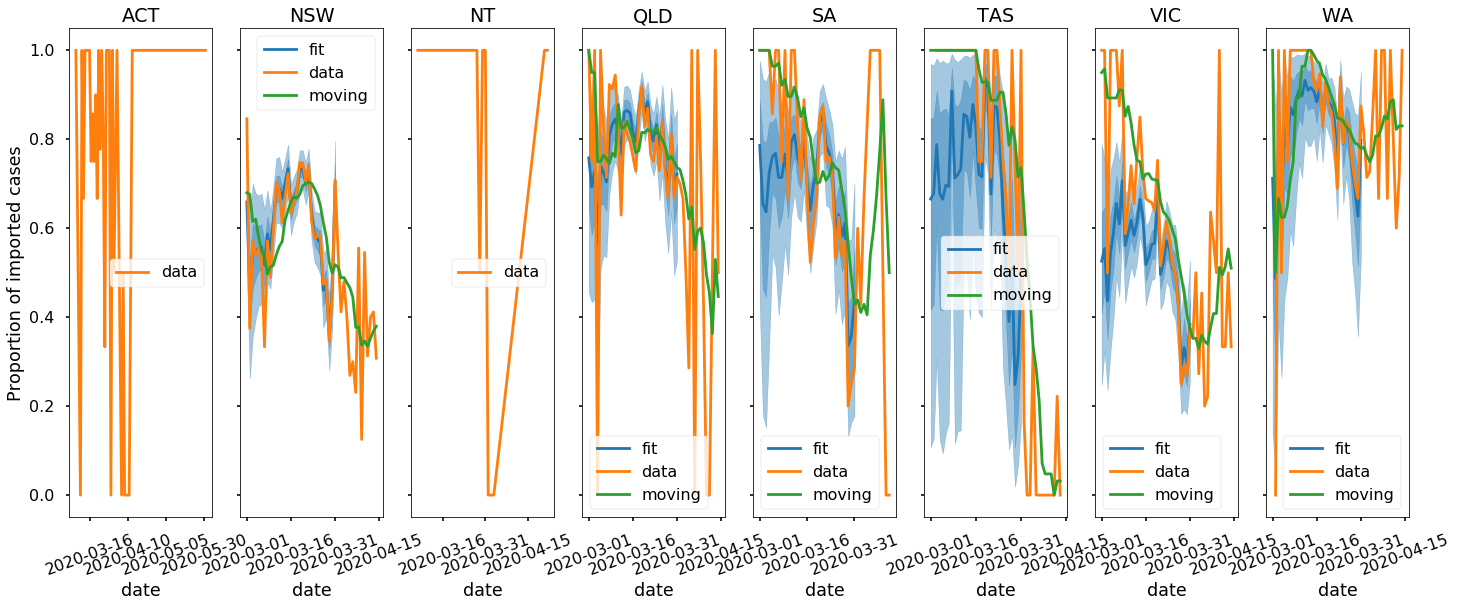

In [9]:
#rho caluclated at data entry
df_state = df_state.reset_index()
states=sorted(['NSW','QLD','VIC','TAS','SA','WA','ACT','NT'])
fig,ax = plt.subplots(figsize=(24,9), ncols=len(states),sharey=True)
states_to_fitd = {state: i+1 for i,state in enumerate(states_to_fit)      }

for i, state in enumerate(states):
    if state in states_to_fit:
        dates = df_Reff.loc[(df_Reff.date>='2020-03-01') & 
                            (df_Reff.state==state)&(df_Reff.date<='2020-03-31')].date
        rho_samples = samples_mov_gamma[['brho['+str(j+1)+','+str(states_to_fitd[state])+']' for j in range(dfX.loc[dfX.state=='NSW'].shape[0])]]
        ax[i].plot(dates, rho_samples.median(),label='fit',color='C0')
        ax[i].fill_between(dates, rho_samples.quantile(0.25),rho_samples.quantile(0.75),color='C0',alpha=0.4)
    
        ax[i].fill_between(dates, rho_samples.quantile(0.05),rho_samples.quantile(0.95),color='C0',alpha=0.4)
    else:
        sns.lineplot(x='date_inferred',y='rho',
             data=df_state.loc[(df_state.date_inferred>='2020-03-01') & (df_state.STATE==state)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho',
             data=df_Reff.loc[(df_Reff.date>='2020-03-01') & (df_Reff.state==state)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho_moving',
             data=df_Reff.loc[(df_Reff.date>='2020-03-01') & (df_Reff.state==state)], ax=ax[i],color='C2',label='moving')
    
    dates = dfX.loc[dfX.state=='NSW'].date
    
    ax[i].tick_params('x',rotation=20)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))    
    ax[i].set_title(state)
ax[0].set_ylabel('Proportion of imported cases')
plt.legend()
plt.show()

/Users/desliu/Documents/GitHub/covid19-forecasting-aus/model/Reff_functions.py:265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if R=='state':


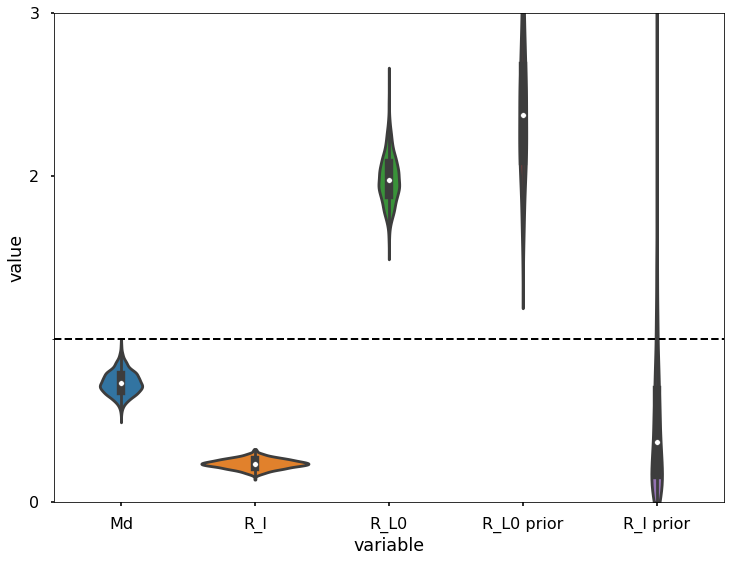

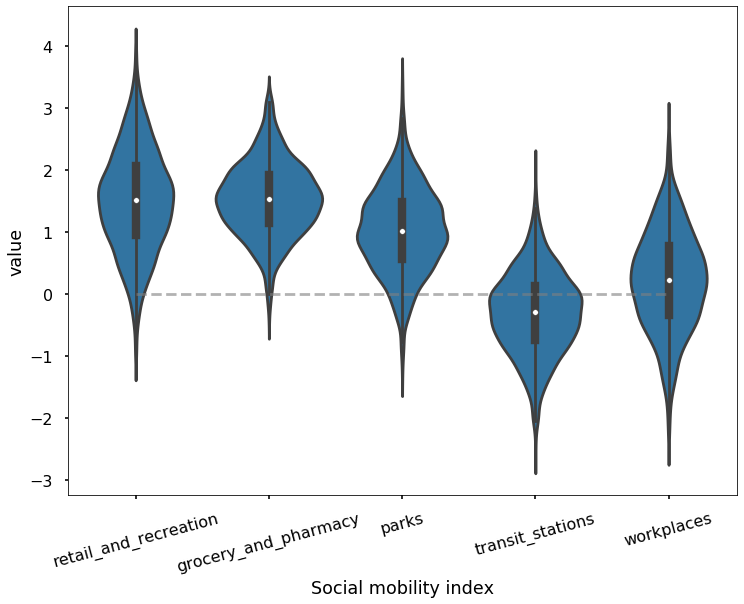

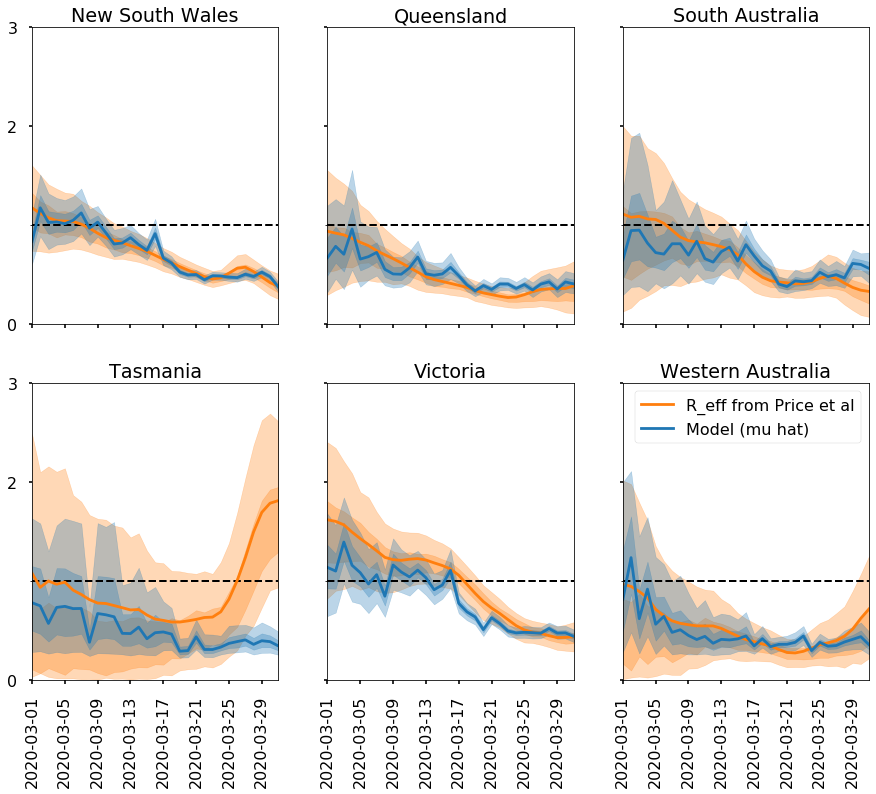

In [10]:
fig,ax = plt.subplots(figsize=(12,9))
samples_mov_gamma['R_L_prior'] = np.random.gamma(
   2.4**2/0.2, 0.2/2.4, size=samples_mov_gamma.shape[0])

samples_mov_gamma['R_I_prior'] = np.random.gamma(
   0.5**2/0.2, .2/0.5, size=samples_mov_gamma.shape[0])

sns.violinplot(x='variable',y='value',
               data=pd.melt(samples_mov_gamma[['md']+[col for col in samples_mov_gamma if 'R' in col]]),
              ax=ax,
              cut=0)

ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_yticklabels([0,2,3],minor=False)
ax.set_ylim((0,3))
ax.set_xticklabels(['Md','R_I','R_L0','R_L0 prior','R_I prior'])
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig("R_md_priors.pdf")

posterior = samples_mov_gamma[['bet['+str(i)+']' for i in range(1,1+len(predictors))] 
                             ] 

split=True
md = samples_mov_gamma.md.values

posterior.columns = [val for val in predictors] 
long = pd.melt(posterior) 

fig,ax2 =plt.subplots(figsize=(12,9))

ax2 = sns.violinplot(x='variable',y='value',#hue='policy',
                    data=long,
                    ax=ax2,
                     color='C0'
                   )


ax2.plot([0]*len(predictors), linestyle='dashed',alpha=0.6, color = 'grey')
ax2.tick_params(axis='x',rotation=90)

#ax =plot_posterior_violin(posterior)

#ax2.set_title('Coefficients of mobility indices')
ax2.set_xlabel('Social mobility index')
ax2.set_xticklabels([var[:-6] for var in mov_values])
ax2.tick_params('x',rotation=15)
plt.savefig('../figs/mobility_posteriors.pdf')

 


ax3 =predict_plot(samples_mov_gamma,df.loc[(df.date>='2020-03-01')&(df.date<='2020-03-31')],gamma=True,
                 moving=True,split=split,grocery=True,ban = ban,
                R=samples_mov_gamma.R_L.values, var= True, md=md,
                 rho=states_to_fit, R_I =samples_mov_gamma.R_I.values)#by states....
for ax in ax3:
    for a in ax:
        a.set_ylim((0,3))
        a.set_xlim(('2020-03-01','2020-03-31'))
plt.savefig("../figs/total_Reff_allstates.pdf")
plt.show()

/Users/desliu/Documents/GitHub/covid19-forecasting-aus/model/Reff_functions.py:265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if R=='state':


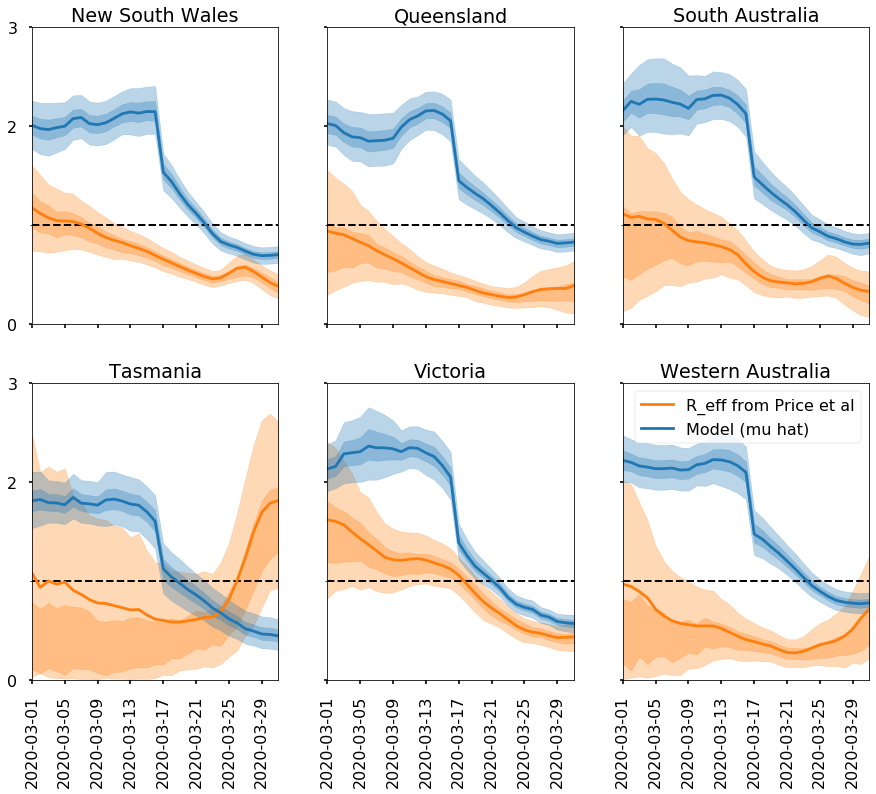

In [11]:
## Just local rates

ax =predict_plot(samples_mov_gamma,df.loc[(df.date>='2020-03-01')],gamma=True,
                 moving=True,split=split,grocery=True, ban=ban,
                R=samples_mov_gamma.R_L.values, var= True, md=md,
                 ) #by states....
for ax1 in ax:
    for a in ax1:
        a.set_ylim((0,3))
        a.set_xlim(('2020-03-01','2020-03-31'))
plt.savefig("../figs/local_Reff_allstates.pdf")
plt.show()

In [12]:
from datetime import datetime
var_to_csv = predictors
samples_mov_gamma[predictors] = samples_mov_gamma[['bet['+str(i)+']' for i in range(1,1+len(predictors))]]
var_to_csv = ['R_I']+['R_L']+['md']+predictors
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')

samples_mov_gamma[var_to_csv].to_hdf('../data/soc_mob_posterior'+today+'.h5',key='samples')

In [13]:
from datetime import datetime
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')
samples_mov_gamma[var_to_csv].to_csv('../data/soc_mob_posterior'+today+'.csv')
samples_mov_gamma[var_to_csv]

### Deprecated code

In [9]:
rho_model_gamma = """
data {
    int N; //data length num days
    int K; //Number of mobility indices
    int j; //Number of states
    matrix[N,j] Reff; //response
    matrix[N,K] Mob[j]; //Mobility indices
    matrix[N,j] sigma2; //Variances of R_eff from previous study
    vector[N] policy; //Indicators for post policy or not
    matrix[N,j] rho; //proportion of imported cases

}
parameters {
    vector[K] beta; //coefficients
    real<lower=0> R_I; //base level imports,
    real<lower=0> R_L; //base level local
    real<lower=0> md; //micro distancing
}
transformed parameters {
    matrix[N,j] mu_hat;
    //vector[N] delta;
    for (i in 1:j) {
        for (n in 1:N){
            mu_hat[n,i] = rho[n,i]*R_I + (1-rho[n,i])*4*R_L*((1-policy[n]) + md*policy[n] )*inv_logit(Mob[i][n,:]*(beta)); //mean estimate
        }
    }
    
}
model {
    beta ~ normal(0,1);
    md ~ gamma(0.5,1);

    
    R_L ~ gamma(2.4,1);
    R_I ~ gamma(0.5*0.5/.2,0.5/.2);
 
    for (i in 1:j) {
        for (n in 1:N){
            mu_hat[n,i] ~ gamma( Reff[n,i]*Reff[n,i]/(sigma2[n,i]), Reff[n,i]/sigma2[n,i]); //Stan uses shape/inverse scale
        }
    }
}
"""

import pystan

sm_pol_gamma = pystan.StanModel(
    model_code = rho_model_gamma,
    model_name ='gamma_pol_state'
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gamma_pol_state_10b239ccf3d7cce872b88e6729bf9576 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/xz/pm_mn5fd3vs9g6dky0lnr8c40000gn/T/tmps64yyf61/stanfit4gamma_pol_state_10b239ccf3d7cce872b88e6729bf9576_2562796186400464814.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [25]:
#Create useable dataset
states_to_fit = sorted(['NSW','VIC','QLD'])#,'SA','WA','TAS']) #sorting keeps consistent with sort in data_by_state
fit_post_March = True
ban = '2020-03-16'

fit_mask = df.state.isin(states_to_fit)
if fit_post_March:
    fit_mask = (fit_mask) & (df.date >= '2020-03-01')
    
fit_mask = (fit_mask) & (df.date <= '2020-03-31')


predictors = mov_values.copy()
#predictors.extend(['driving_7days','transit_7days','walking_7days','pc'])

#remove residential to see if it improves fit
predictors.remove('residential_7days')

df['post_policy'] = (df.date >= ban).astype(int)

dfX = df.loc[fit_mask].sort_values('date')
data_by_state= {}

for value in ['mean','std','rho_moving']:
    data_by_state[value] = pd.pivot(dfX[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
mobility_by_state =[]
for state in states_to_fit:
    print(state)
    mobility_by_state.append(dfX.loc[dfX.state==state, predictors].values/100)
policy = dfX.loc[dfX.state=='NSW','post_policy']

NSW
QLD
VIC


In [26]:
##Make state by state arrays
input_data ={
    'N': dfX.loc[dfX.state=='NSW'].shape[0],
    'K': len(predictors),
    'j':len(states_to_fit),
    'Reff': data_by_state['mean'].values,
    'Mob': mobility_by_state,
    'sigma2': data_by_state['std'].values**2,
    'policy': policy.values,
    'rho': data_by_state['rho_moving'].values,
}
iterations=2000
chains=2
fit = sm_pol_gamma.sampling(
    data=input_data,
    iter=iterations,
    chains=chains
)


print(fit.stansummary(pars=['beta','R_I','R_L','md']))
samples_mov_gamma = fit.to_dataframe(pars=['beta','R_I','R_L','md'])

RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=local; base type=matrix_d  (in 'unknown file name' at line 10)


KeyError: "None of [Index(['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], dtype='object')] are in the [columns]"

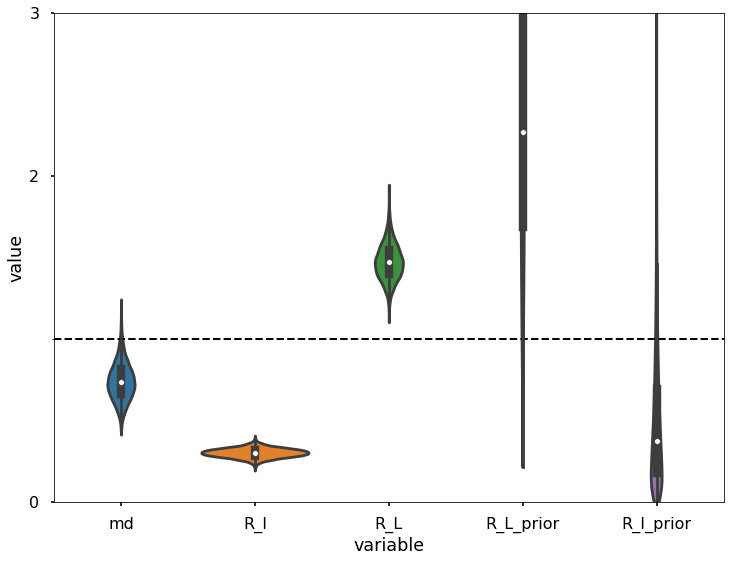

In [24]:
fig,ax = plt.subplots(figsize=(12,9))
samples_mov_gamma['R_L_prior'] = np.random.gamma(
   2.4**2, 1/2.4, size=samples_mov_gamma.shape[0])

samples_mov_gamma['R_I_prior'] = np.random.gamma(
   0.5**2/0.2, .2/0.5, size=samples_mov_gamma.shape[0])

sns.violinplot(x='variable',y='value',
               data=pd.melt(samples_mov_gamma[['md']+[col for col in samples_mov_gamma if 'R' in col]]),
              ax=ax,
              cut=0)

ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_yticklabels([0,2,3],minor=False)
ax.set_ylim((0,3))

ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig("R_md_priors.pdf")

posterior = samples_mov_gamma[['beta['+str(i)+']' for i in range(1,1+len(predictors))] 
                             ] 

split=True
md = samples_mov_gamma.md.values

posterior.columns = [val for val in predictors] 
long = pd.melt(posterior) 

fig,ax2 =plt.subplots(figsize=(12,9))

ax2 = sns.violinplot(x='variable',y='value',#hue='policy',
                    data=long,
                    ax=ax2,
                     color='C0'
                   )
ax2.plot([0]*len(predictors), linestyle='dashed',alpha=0.6, color = 'grey')
ax2.tick_params(axis='x',rotation=90)
#ax =plot_posterior_violin(posterior)

#ax2.set_title('Coefficients of mobility indices')
ax2.set_xlabel('Social mobility index')
ax2.set_xticklabels([var[:-6] for var in mov_values])
ax2.tick_params('x',rotation=15)
plt.savefig('mobility_posteriors.pdf')

 


ax3 =predict_plot(samples_mov_gamma,df.loc[(df.date>='2020-03-01') & (df.date<='2020-03-31')],gamma=True,
                 moving=True,split=split,grocery=True,
                R=samples_mov_gamma.R_L.values, var= True, md=md,
                 rho=True, R_I =samples_mov_gamma.R_I.values)#by states....
#plt.savefig("total_Reff_allstates.pdf")
plt.show()

In [ ]:
## Just local rates

ax =predict_plot(samples_mov_gamma,df.loc[df.date>='2020-03-01'],gamma=True,
                 moving=True,split=split,grocery=True,
                R=samples_mov_gamma.R_L.values, var= True, md=md,
                 ) #by states....

#plt.savefig("local_Reff_allstates.pdf")
plt.show()

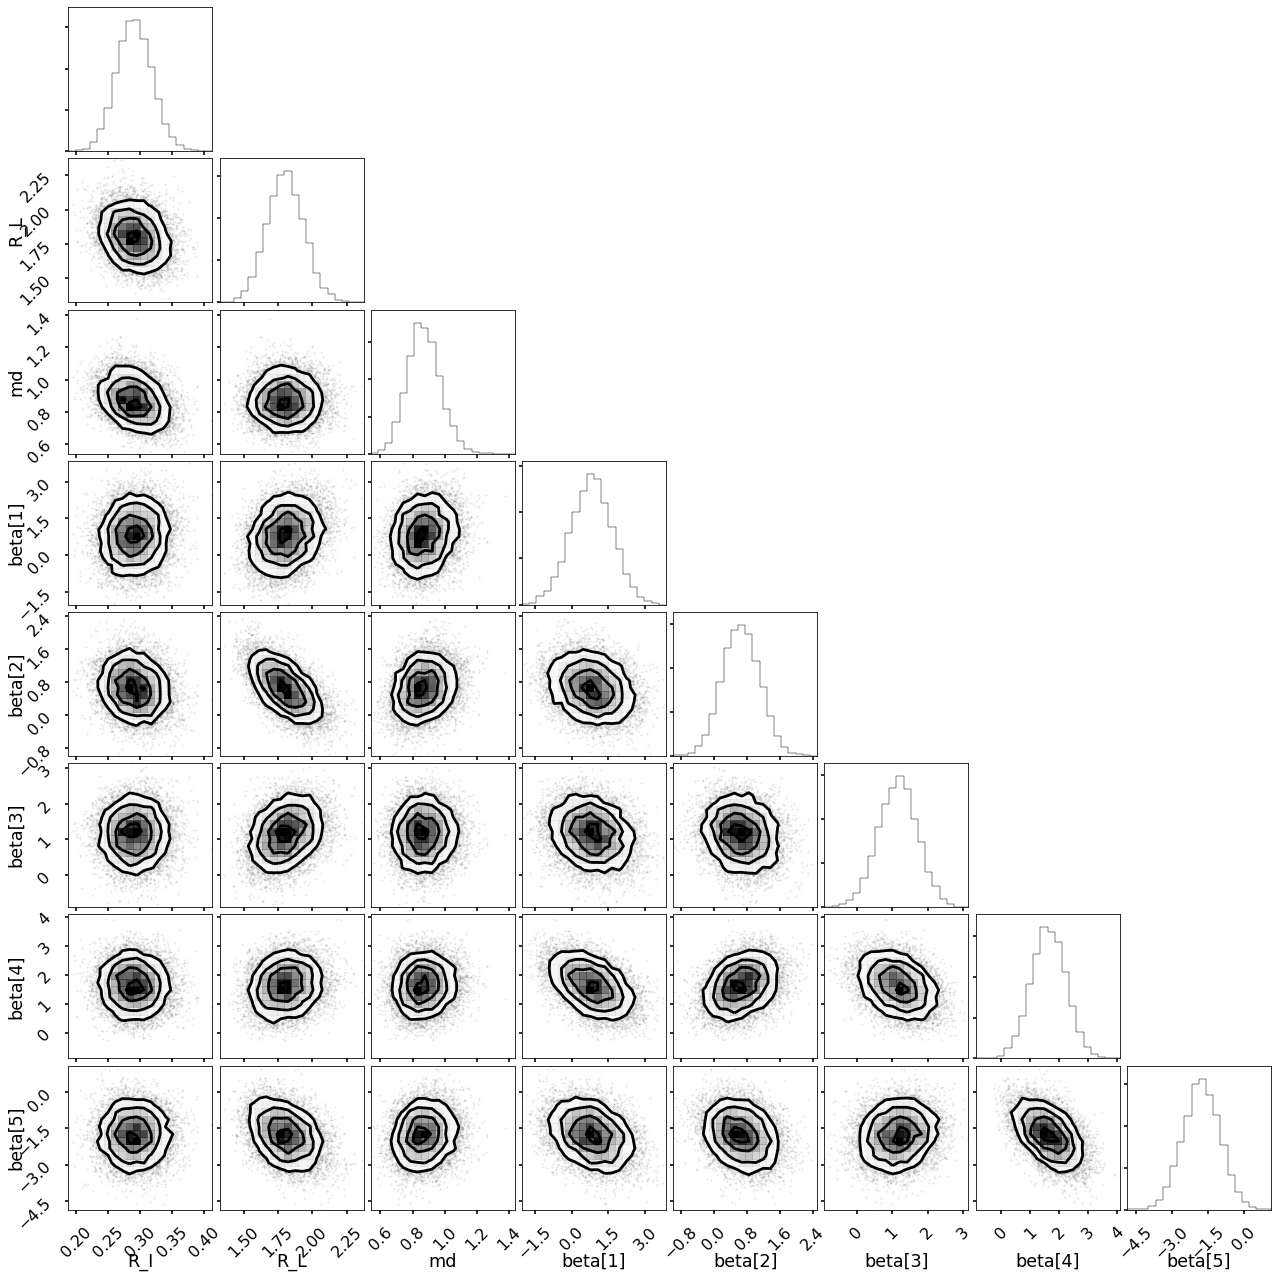

In [63]:
from corner import corner

corner(samples_mov_gamma[['R_I','R_L','md','beta[1]','beta[2]','beta[3]','beta[4]','beta[5]']])

plt.show()

In [18]:
def set_baseline_val(df, col:str, end_date, start_date=None, interval=None):
    """
    Given a column name and date start, append a new column to the df with new baseline based on same day of week
    """
    from datetime import datetime as dt
    from datetime import timedelta
   
    if start_date is None:
        start_date = end_date + timedelta(days=interval)
    
    mask = generate_mask(df['date'], start_date=start_date, end_date=end_date)
        
    df_filtered = df.loc[mask]
    days =  df_filtered.day.unique() # Days to consider as baseline
    
    for day in days:
        id_map ={}
        for sa2 in df_filtered.id:
        # Iterate over each id 
            try:
                id_map[sa2] = df_filtered.loc[(df_filtered.day==day)
                                              & (df_filtered.id==sa2), col].values[0]
            except IndexError:
                print(str(sa2) + 'id region on day '+str(day) +' does not have data')
                continue
                    
        df.loc[df.day==day,'base_'+col+dt.strftime(start_date,format='%Y-%m-%d')] = df.loc[df.day==day].id.map(id_map)
    
    return df

def percentage_change(df, base:str, newcol:str, val:str):
    """
    Calculate percentage change of column val from baseline col into a newcol that is a percentage change
    """
    
    df[newcol] = (df[val] - df[base])/df[base] * 100
    return df

def generate_mask(s_date,start_date=None, end_date=None, interval=None ):
    """
    Generate mask to based on if s_date lies within (inclusive of) a date range.
    Note: to use timedelta, need dates to include timezone
    """
    from datetime import timedelta
    if start_date is None:  
        start_date = end_date + timedelta(days=interval)
    elif end_date is None:
        end_date = start_date + timedelta(days=interval)
             
    mask = (s_date >= start_date) & (s_date <= end_date)

    return mask

In [2]:
start = dt.strptime('2020-01-20+0000', '%Y-%m-%d%z')
end = dt.strptime('2020-04-27+0000','%Y-%m-%d%z')
mask = generate_mask(df_ai.date, start_date=start, end_date=end)

start = dt.strptime('2019-01-20+0000', '%Y-%m-%d%z')
end = dt.strptime('2019-04-27+0000','%Y-%m-%d%z')
mask2 = generate_mask(df_ai.date, start_date=start, end_date=end)

PH2019 = (dt.strptime('2019-04-19+0000', '%Y-%m-%d%z'), 
              dt.strptime('2019-04-20+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-21+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-22+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-25+0000', '%Y-%m-%d%z')
         )

NameError: name 'generate_mask' is not defined